# Market basket analysis 

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import json
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import combinations
import time
import pickle

In [ ]:
os.environ['KAGGLE_USERNAME'] = "jadyehya"
os.environ['KAGGLE_KEY'] = "a3adb25c84ad6eb2dde06a24dbb53302"
!kaggle datasets download -d yelp-dataset/yelp-dataset

We processed the buckets and tokenized them in a .py file, to allow the use of multiprocessing. (We had issues with the notebook crashing when using multiprocessing in the notebook itself.) The file is called "preprocessing.py" and is in the same folder as this notebook. It generates the file "transactions.txt" which is used in this notebook.

In [2]:
# Load transactions from a file
transactions = []
with open('transactions.txt', 'r') as f:
    for line in f:
        transactions.append(line.split())

# A priori algorithm

In [3]:
# Calculate the support of itemsets
def calculate_support(transactions, itemset, min_support):
    """
    transactions: A list of transactions
    itemset: A list of items
    min_support: The minimum support threshold
    Returns: (Bool, Calculated support of the itemset)
    """
    count = 0
    for transaction in transactions:
        if all(item in transaction for item in itemset):
            count += 1
    support = count / len(transactions)
    return support >= min_support, count

# Another version of the function
def calculate_support(itemset, transactions):
    count = 0
    for transaction in transactions:
        if all(item in transaction for item in itemset):
            count += 1
    return count / len(transactions)

# Generate candidate itemsets of a given size
def generate_candidate_itemsets(itemsets, k):
    """
    itemsets: A list of frequent itemsets of size k - 1
    k: Size of the frequent itemsets to generate
    Returns: A list of candidate itemsets of size k
    """
    candidates = []
    for i, itemset1 in enumerate(itemsets):
        for itemset2 in itemsets[i+1:]:
            if itemset1[:-1] == itemset2[:-1]:
                candidates.append(itemset1 + [itemset2[-1]])
    return candidates

# Prune infrequent itemsets
def prune_itemsets(itemsets, k_minus_1_itemsets):
    """
    itemsets: A list of candidate itemsets of size k
    k_minus_1_itemsets: A list of frequent itemsets of size k - 1
    Returns: A list of frequent itemsets of size k
    """
    pruned_itemsets = []
    for itemset in itemsets:
        subsets = list(combinations(itemset, k_minus_1_itemsets))
        if all(subset in k_minus_1_itemsets for subset in subsets):
            pruned_itemsets.append(itemset)
    return pruned_itemsets

# Perform Apriori algorithm
def apriori(transactions, min_support):
    """
    transactions: A list of transactions
    min_support: The minimum support threshold
    Returns: A list of (itemset, count)
    """
    itemsets = [[item] for item in set(item for transaction in transactions for item in transaction)]
    frequent_itemsets = []
    k = 1

    while itemsets:
        candidates = generate_candidate_itemsets(itemsets, k)
        itemsets = []
        for candidate in candidates:
            is_frequent, count = calculate_support(transactions, candidate, min_support)
            if is_frequent:
                itemsets.append(candidate)
                frequent_itemsets.append((candidate, count))
        k += 1

    return frequent_itemsets

We do some benchmarks (that won't even finish because they take too long, more on that in the report)

In [20]:
min_support = 0.2

times = []
sizes = [100, 1000, 10000, 100000, 200000, len(transactions)]
for size in sizes:
    if size == sizes[1]:
        break
    print("Size: ", size)
    start = time.time()
    frequent_itemsets = apriori(transactions[:size], min_support*(size)//10)
    end = time.time()
    times.append(end-start)
    print("Time taken: ", end-start)
    print()

Size:  100
Time taken:  141.90046882629395



In [4]:

with open("frequent_itemsets_pcy.pkl", "rb") as f:
    frequent_itemsets_with_count = pickle.load(f)

In [5]:
frequent_itemsets = [itemset for itemset, count in frequent_itemsets_with_count]

In [6]:
frequent_itemsets[:15]

[('come', 'time'),
 ('come', 'food'),
 ('come', 'good'),
 ('come', 'like'),
 ('eat', 'time'),
 ('eat', 'food'),
 ('eat', 'good'),
 ('eat', 'like'),
 ('many', 'food'),
 ('many', 'like'),
 ('never', 'food'),
 ('never', 'good'),
 ('never', 'like'),
 ('restaurant', 'food'),
 ('restaurant', 'good')]

In [ ]:
min_confidence = 0.2

association_rules = generate_association_rules(frequent_itemsets, min_confidence, transactions)

# Print the generated association rules
for rule in association_rules:
    antecedent, consequent, support, confidence = rule
    print(f"Rule: {antecedent} => {consequent}")
    print(f"Support: {support}")
    print(f"Confidence: {confidence}")
    print()


In [ ]:
# Saving the association rules to a file csv
with open('association_rules.csv', 'w') as f:
    f.write('antecedent;consequent;support;confidence\n')
    for rule in association_rules:
        antecedent, consequent, support, confidence = rule
        f.write(f"{' '.join(antecedent)};{' '.join(consequent)};{support};{confidence}\n")

In [7]:
association_rules = pd.read_csv('association_rules_apriori.csv', sep=';')

In [8]:
association_rules

,antecedent,consequent,support,confidence
0,menu,good,0.046106,0.470149
1,half,really,0.009802,0.263348
2,half,great,0.011061,0.297180
3,going,really,0.023870,0.254601
4,going,get,0.034748,0.370625
...,...,...,...,...
715,fun maybe one good,really well,0.000133,0.262899
716,really fun well maybe one,good,0.000133,0.668750
717,really fun well maybe good,one,0.000133,0.699346
718,really fun maybe one good,well,0.000133,0.473451


## Doing benchmarks

In [9]:
# Sorting the association rules by confidence
association_rules.sort_values(by='confidence', ascending=False, inplace=True)
# Taking the top 100 association rules
a100 = association_rules.head(100)

In [10]:
a100.head(9)

,antecedent,consequent,support,confidence
630,really fun well maybe,one,0.000199,0.704846
717,really fun well maybe good,one,0.000133,0.699346
597,going really hard water,get,0.000152,0.697143
660,really well maybe one,good,0.001434,0.684524
707,really tour needed one great,us,0.000016,0.684211
635,really fun well maybe,good,0.000191,0.674009
716,really fun well maybe one,good,0.000133,0.668750
693,experience order usually good,food,0.000428,0.666019
555,experience order good,food,0.004983,0.665723


In [11]:
# Make the antecedent a tuple
association_rules['antecedent'] = association_rules['antecedent'].apply(lambda x: tuple(x.split()))

In [12]:
association_rules.head()

,antecedent,consequent,support,confidence
630,"(really, fun, well, maybe)",one,0.000199,0.704846
717,"(really, fun, well, maybe, good)",one,0.000133,0.699346
597,"(going, really, hard, water)",get,0.000152,0.697143
660,"(really, well, maybe, one)",good,0.001434,0.684524
707,"(really, tour, needed, one, great)",us,0.000016,0.684211


In [13]:
# Getting the association rules where the anteceedent is length 2 and sorting them by confidence
association_rules[association_rules['antecedent'].apply(len) == 2].sort_values(by='confidence', ascending=False).head(10)

,antecedent,consequent,support,confidence
233,"(really, maybe)",good,0.007368,0.605781
301,"(experience, order)",food,0.009507,0.595378
330,"(order, good)",food,0.027924,0.590296
118,"(menu, lots)",good,0.002447,0.575154
319,"(well, maybe)",good,0.005046,0.572338
347,"(food, usually)",good,0.008005,0.560590
116,"(menu, next)",good,0.006195,0.557063
326,"(order, usually)",food,0.003986,0.552159
209,"(really, well)",good,0.020115,0.548104
359,"(maybe, one)",good,0.008086,0.537410


In [14]:
# Getting the association rules where the anteceedent is length 3 and sorting them by confidence
association_rules[association_rules['antecedent'].apply(len) == 3].sort_values(by='confidence', ascending=False).head(10)

,antecedent,consequent,support,confidence
555,"(experience, order, good)",food,0.004983,0.665723
471,"(really, well, maybe)",good,0.002417,0.663587
367,"(menu, next, lots)",good,0.000391,0.655532
495,"(really, maybe, one)",good,0.003717,0.634931
551,"(experience, order, usually)",food,0.000693,0.631101
534,"(fun, well, maybe)",one,0.000343,0.625000
527,"(tour, needed, great)",us,0.000074,0.621053
399,"(going, hard, water)",get,0.000277,0.620112
567,"(well, maybe, one)",good,0.002753,0.615556
572,"(order, usually, good)",food,0.002269,0.615073


In [15]:
# Getting the association rules where the anteceedent is length 4 and sorting them by confidence
association_rules = association_rules[association_rules['antecedent'].apply(len) == 4]
association_rules.sort_values(by='confidence', ascending=False, inplace=True)
association_rules

/Users/jadyehya/opt/anaconda3/envs/Anaconda_env/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,antecedent,consequent,support,confidence
630,"(really, fun, well, maybe)",one,0.000199,0.704846
597,"(going, really, hard, water)",get,0.000152,0.697143
660,"(really, well, maybe, one)",good,0.001434,0.684524
635,"(really, fun, well, maybe)",good,0.000191,0.674009
693,"(experience, order, usually, good)",food,0.000428,0.666019
...,...,...,...,...
712,"(really, fun, maybe, good)",well one,0.000133,0.270886
696,"(need, clean, like, even)",work,0.000196,0.266553
715,"(fun, maybe, one, good)",really well,0.000133,0.262899
699,"(clean, like, even, work)",need,0.000196,0.245696


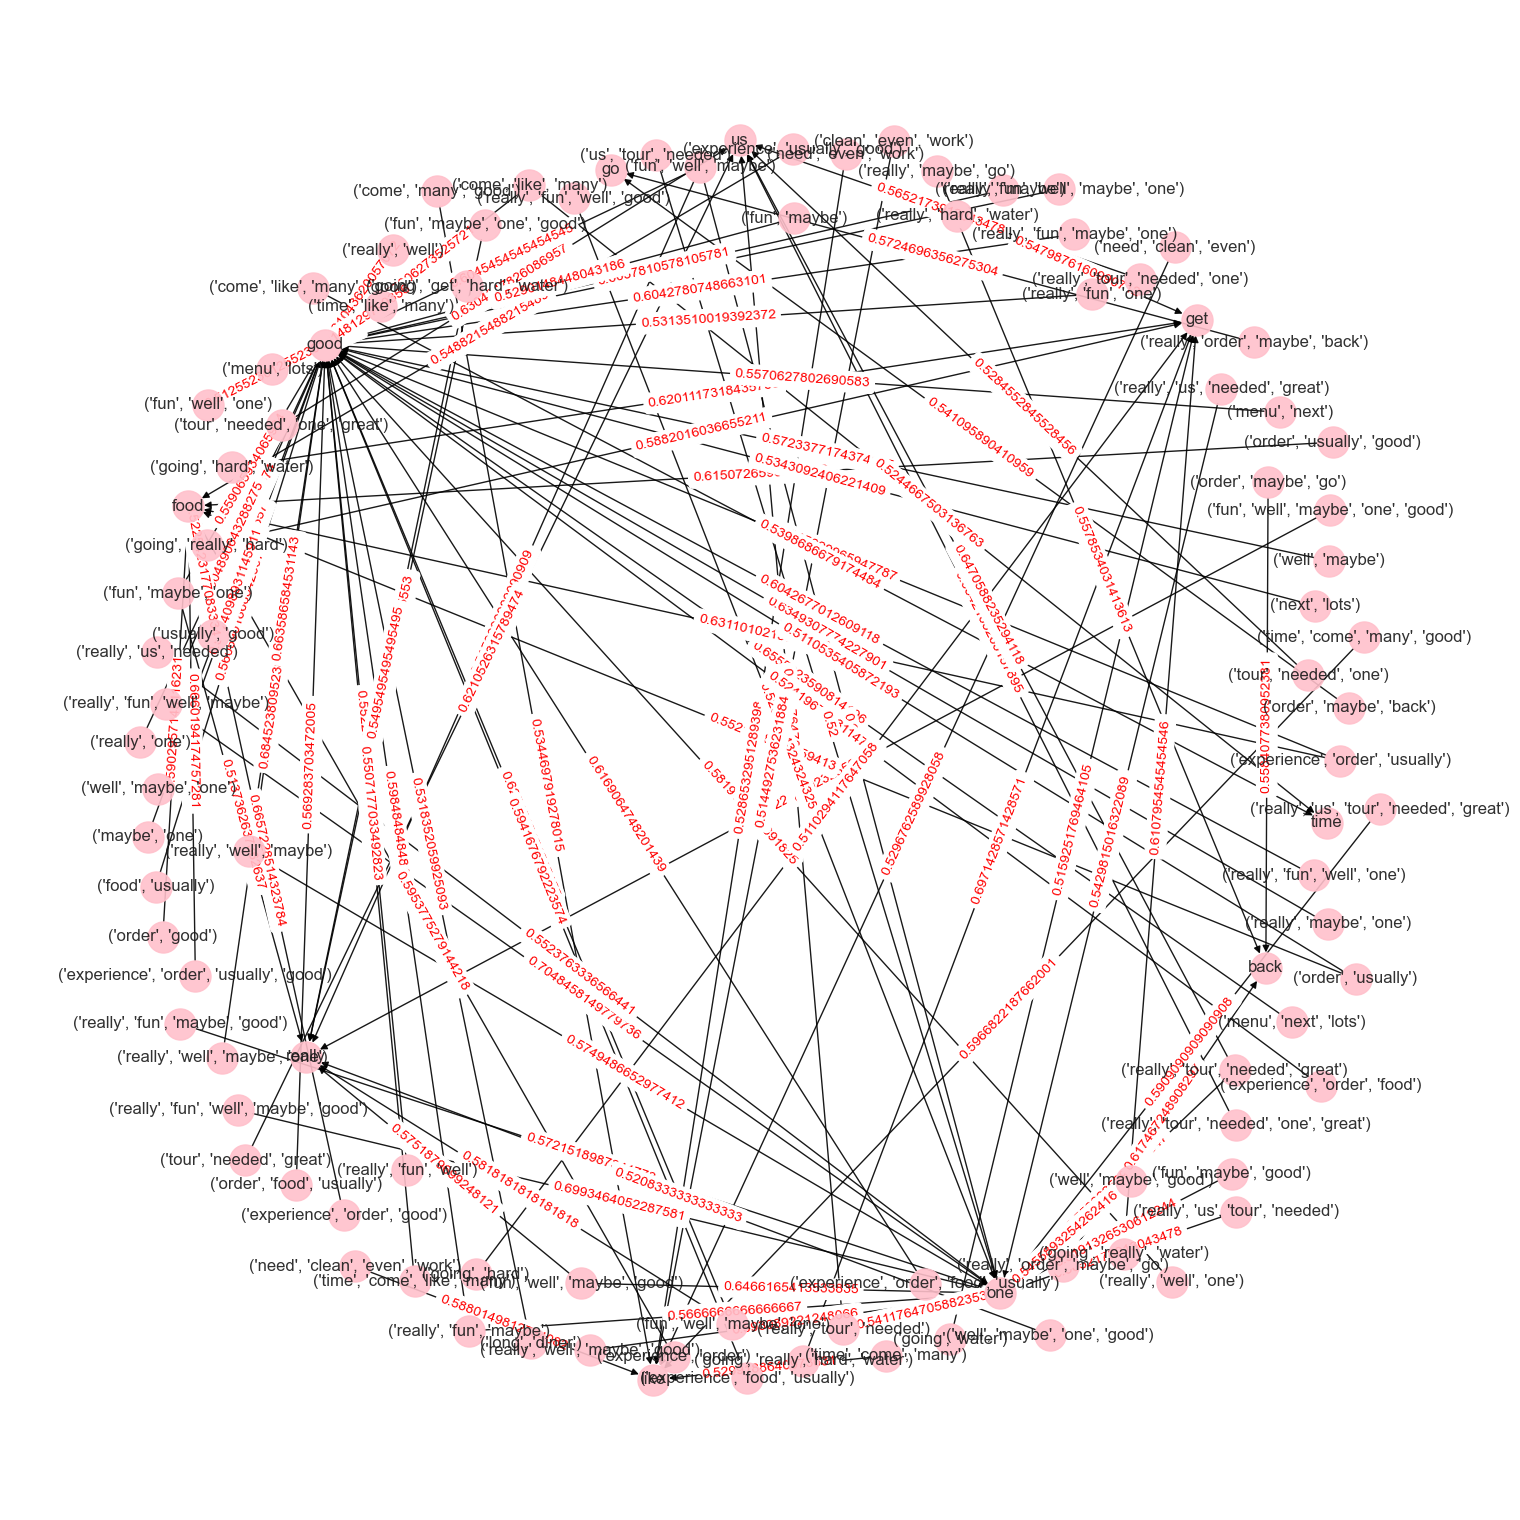

In [95]:
# Creating a graph of the association rules
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(association_rules):
    G = nx.DiGraph()
    for index, rule in a100.iterrows():
        G.add_edge(rule['antecedent'], rule['consequent'], weight=rule['confidence'])
    return G

G = create_graph(association_rules)

# Drawing the graph with seaborn
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
pos = nx.spring_layout(G, k=10)
nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node for node in G.nodes()})
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.axis('off')

nx.write_gexf(G, 'association_rules.gexf')


plt.savefig('association_rules.jpeg' , dpi=300)

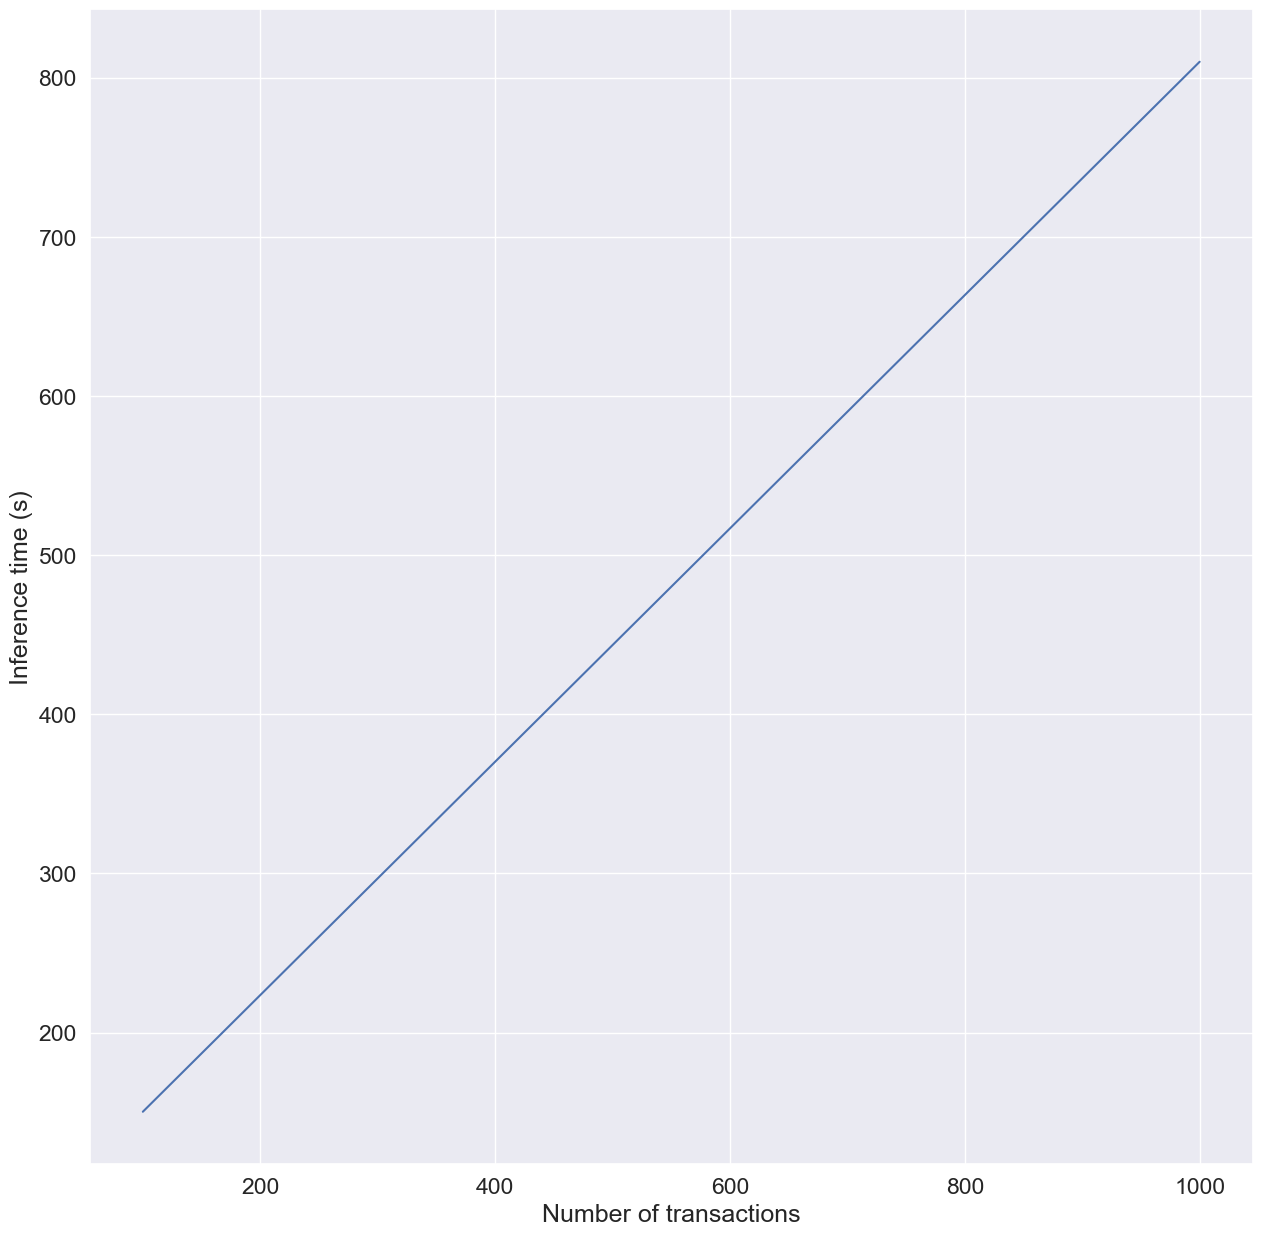

In [96]:
x_ap = [100, 1000]
y_ap = [150.20139622688293, 810]
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
plt.plot(x_ap, y_ap)
plt.xlabel('Number of transactions')
plt.ylabel('Inference time (s)')

plt.savefig('inference_time_apriori.jpeg' , dpi=300)

# PCY algorithm

In [97]:
def PCY(transactions, min_support, hash_table_size):
    # First pass - Counting frequent single items
    single_item_counts = {}
    for transaction in transactions:
        for item in transaction:
            single_item_counts[item] = single_item_counts.get(item, 0) + 1

    frequent_single_items = set(
        [item for item, count in single_item_counts.items() if count >= min_support]
    )

    # Second pass - Counting frequent pairs and triplets
    candidate_counts = {}
    hash_table = np.zeros((hash_table_size,), dtype=int)

    for transaction in tqdm(transactions):
        items = set(transaction)

        # Generate candidate pairs
        pairs = combinations(items, 2)
        candidate_pairs = [(item1, item2) for item1, item2 in pairs if item1 in frequent_single_items and item2 in frequent_single_items]

        # Count candidate pairs in the hash table
        for pair in candidate_pairs:
            hash_value = hash(pair) % hash_table_size
            hash_table[hash_value] += 1
            candidate_counts[pair] = candidate_counts.get(pair, 0) + 1

        # Generate candidate triplets
        triplets = combinations(items, 3)
        candidate_triplets = [(item1, item2, item3) for item1, item2, item3 in triplets if
                              (item1, item2) in candidate_pairs and (item1, item3) in candidate_pairs and (item2, item3) in candidate_pairs]

        # Count candidate triplets in the hash table
        for triplet in candidate_triplets:
            hash_value = hash(triplet) % hash_table_size
            hash_table[hash_value] += 1
            candidate_counts[triplet] = candidate_counts.get(triplet, 0) + 1

    # Filter frequent itemsets based on minimum support and hash table counts
    frequent_itemsets = [(itemset, count) for itemset, count in candidate_counts.items() if count >= min_support and hash_table[hash(itemset) % hash_table_size] >= min_support]

    return frequent_itemsets

In [98]:
# Testing with only 1000 transactions
min_support = 100
hash_table_size = 10000

frequent_itemsets = PCY(transactions[:1000], min_support, hash_table_size)

# Print the frequent itemsets
for itemset in frequent_itemsets:
    print(itemset)

100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]

(('food', 'good'), 168)
(('time', 'great'), 100)
(('one', 'good'), 103)
(('service', 'food'), 143)
(('service', 'good'), 123)
(('one', 'place'), 100)
(('food', 'place'), 104)
(('great', 'food'), 114)


In [101]:
def calculate_support(itemset, transactions):
    """Calculate the support of an itemset in a list of transactions"""
    count = 0
    for transaction in transactions:
        if set(itemset).issubset(transaction):
            count += 1
    return count / len(transactions)

def generate_association_rules(frequent_itemsets, min_confidence, transactions):
    """
    frequent_itemsets: List of frequent itemsets
    min_confidence: Minimum confidence threshold
    transactions: List of transactions
    """
    association_rules = []
    for itemset, count in frequent_itemsets:
        if len(itemset) > 1:
            subsets = generate_subsets(itemset)
            for subset in subsets:
                antecedent = subset
                consequent = tuple(item for item in itemset if item not in antecedent)
                support_antecedent = calculate_support(antecedent, transactions)
                support_itemset = calculate_support(itemset, transactions)
                confidence = support_itemset / support_antecedent
                if confidence >= min_confidence:
                    association_rules.append((antecedent, consequent, support_itemset, confidence))
    return association_rules

In [102]:
min_confidence = 0.5

# Generate association rules
association_rules = generate_association_rules(frequent_itemsets, min_confidence, transactions[:100])

# Print the generated association rules
for rule in association_rules:
    antecedent, consequent, support, confidence = rule
    print(f"Antecedent: {antecedent}")
    print(f"Consequent: {consequent}")
    print(f"Support: {support}")
    print(f"Confidence: {confidence}")
    print("---")

Antecedent: ('one',)
Consequent: ('good',)
Support: 0.09
Confidence: 0.5
---
Antecedent: ('service',)
Consequent: ('food',)
Support: 0.14
Confidence: 0.6666666666666667
---


## PCY using MapReduce

In [103]:
def mapper(transactions, frequent_single_items):
    candidate_counts = {}
    hash_table = np.zeros((hash_table_size,), dtype=int)

    for transaction in transactions:
        items = set(transaction)

        # Generate candidate pairs
        pairs = combinations(items, 2)
        candidate_pairs = [(item1, item2) for item1, item2 in pairs if item1 in frequent_single_items and item2 in frequent_single_items]

        # Count candidate pairs in the hash table
        for pair in candidate_pairs:
            hash_value = hash(pair) % hash_table_size
            hash_table[hash_value] += 1
            candidate_counts[pair] = candidate_counts.get(pair, 0) + 1

    return candidate_counts, hash_table

def reducer(mapped_data, min_support, hash_table_size):
    frequent_itemsets = []

    candidate_counts = {}
    hash_table = np.zeros((hash_table_size,), dtype=int)

    for mapped_itemsets, mapped_hash_table in mapped_data:
        for itemset, count in mapped_itemsets.items():
            candidate_counts[itemset] = candidate_counts.get(itemset, 0) + count
            hash_value = hash(itemset) % hash_table_size
            hash_table[hash_value] += count

    # Filter frequent itemsets based on minimum support and hash table counts
    frequent_itemsets = [(itemset, count) for itemset, count in candidate_counts.items() if count >= min_support and hash_table[hash(itemset) % hash_table_size] >= min_support]

    return frequent_itemsets

def PCY_mr(transactions, min_support, hash_table_size, chunk_size):
    # First pass - Counting frequent single items
    single_item_counts = {}
    for transaction in transactions:
        for item in transaction:
            single_item_counts[item] = single_item_counts.get(item, 0) + 1

    frequent_single_items = set(
        [item for item, count in single_item_counts.items() if count >= min_support]
    )

    # Divide transactions into chunks
    chunks = [transactions[i:i+chunk_size] for i in range(0, len(transactions), chunk_size)]

    # Map phase
    mapped_data = []
    for chunk in chunks:
        mapped_data.append(mapper(chunk, frequent_single_items))

    # Reduce phase
    frequent_itemsets = reducer(mapped_data, min_support, hash_table_size)

    return frequent_itemsets

In [105]:
# This is only to check if the code works correctly with the MapReduce.
# The code is not optimized for performance.

min_support = 1000
hash_table_size = 10000

frequent_itemsets_mr = PCY_mr(transactions[:1000], min_support, hash_table_size, 10000)

We then parallelize the PCY algorithm using MapReduce, but again had to do it in a seperate file, called "pcy_multi.py". It generates the file "frequent_itemsets_pcy.pkl" which is used in this notebook.
The file also creates a pkl file with benchmarking times. we will use it to plot the results.

## Benchmarking PCY

In [107]:
# Load pkl file of inference time
import pickle
with open('pcy_times.pkl', 'rb') as f:
    pcy_times = pickle.load(f)

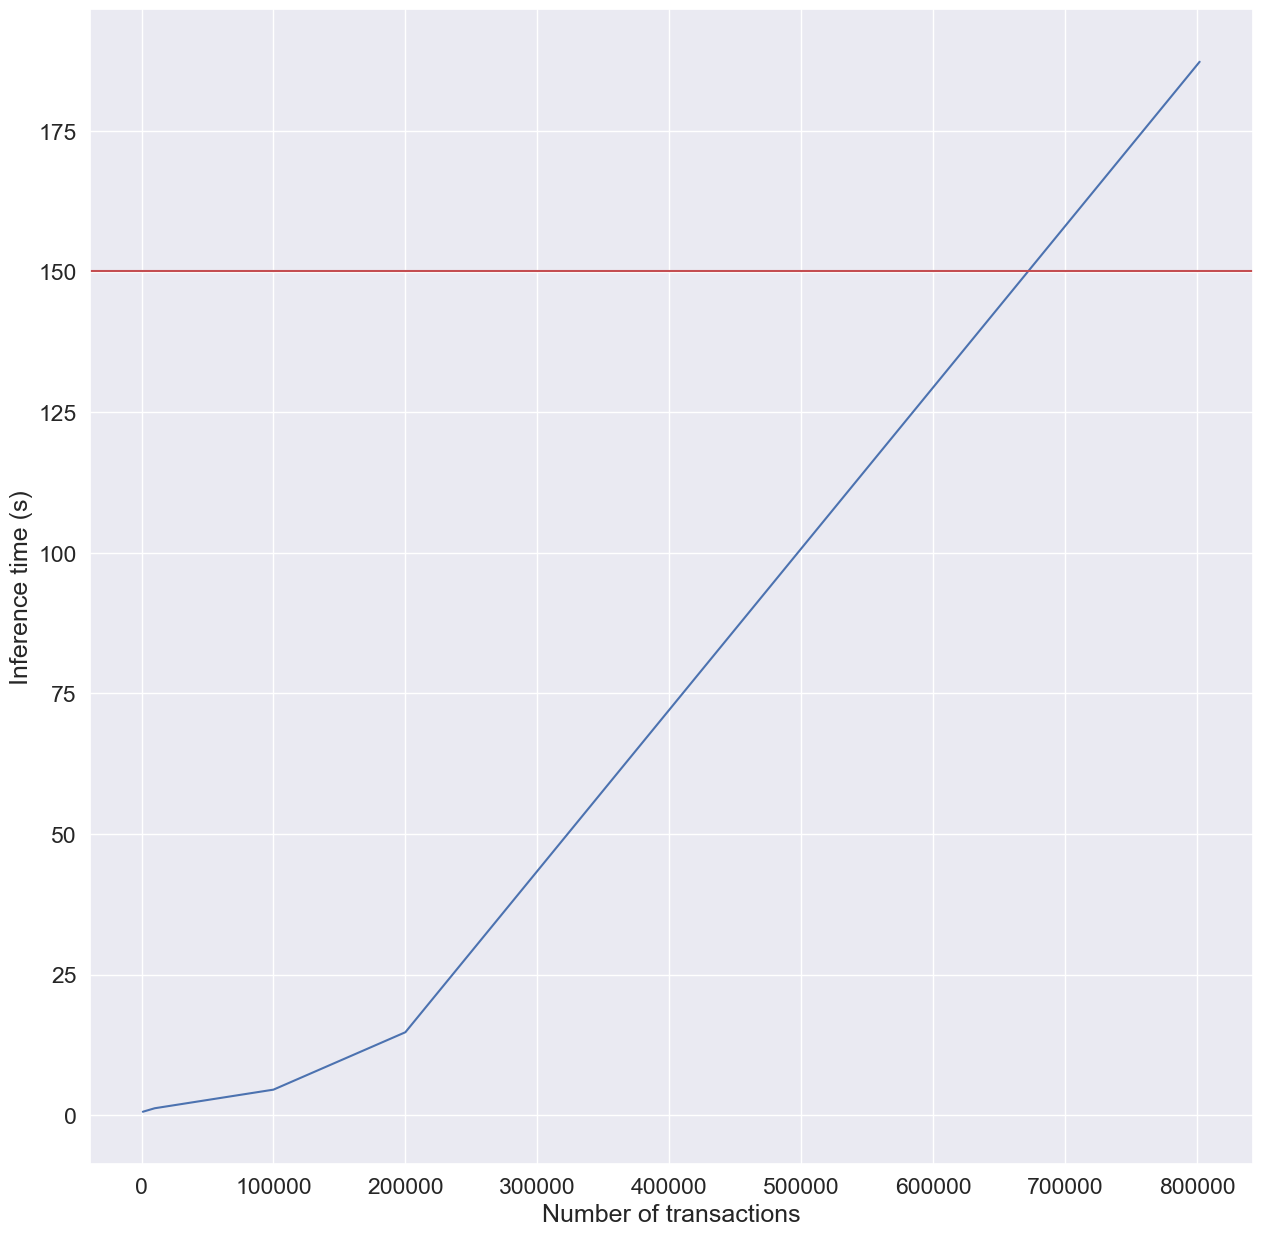

In [108]:
x = [1000, 10000, 100000, 200000, len(transactions)]
# Draw a graph with the inference time for pcy and apriori
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
plt.plot(x, pcy_times)
plt.xlabel('Number of transactions')
plt.ylabel('Inference time (s)')
plt.ScalarFormatter(useMathText=True)
# Plot a horizontal line for the inference time of apriori
plt.axhline(y=150.20139622688293, color='r', linestyle='-')
plt.savefig('inference_time_pcy.jpeg' , dpi=300)
plt.show()